In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating project at `~/Coding/julia/FUSE`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1423


In [5]:
if false
    ϵ = 0.48
    κ = 1.68
    δ = 0.21
    R0 = 6.2
    B0 = 5.3
    ip = 15.E6
    βn = 1.0
    x_point = (5.0, -6.5)
    symmetric=true

    resolution = 129

    dd = IMAS.dd()
    resize!(dd.equilibrium.time_slice,1)
    FUSE.init(dd.equilibrium.time_slice[1]; B0, R0, ϵ, δ, κ, beta_n=βn, ip, x_point=x_point)
    
    eqactor = FUSE.SolovevEquilibriumActor(dd.equilibrium.time_slice[1], symmetric=symmetric)
    @time FUSE.step(eqactor)
    dd.equilibrium.time_slice[1] = FUSE.finalize(eqactor, resolution, (maximum([R0*(1-ϵ*2),0.0]), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2))
    dd.equilibrium.time_slice[1].global_quantities.li_3 = 1.0 # made up!
    dd.equilibrium.time_slice[1].time = 0.0
    dd.equilibrium.time = [0.0]
    dd.equilibrium.vacuum_toroidal_field.r0 = R0
    dd.equilibrium.vacuum_toroidal_field.b0 = [B0]

    plot(dd.equilibrium.time_slice[1], color=:green, psi_levels_out=[])
    #dd.equilibrium.time_slice[1];
elseif false
    filename=joinpath(dirname(abspath(@__FILE__)), "..", "sample","CAT_eq_ods.json")
    dd = IMAS.json2imas(filename);
    @time IMAS.flux_surfaces(dd.equilibrium);
    nothing
else
    filename=joinpath(dirname(abspath(@__FILE__)), "..", "sample","ITER_eq_ods.json")
    dd = IMAS.json2imas(filename);
    @time IMAS.flux_surfaces(dd.equilibrium);
    nothing
end

equilibrium.ids_properties was skipped in IMAS.jl data dictionary
 14.349657 seconds (77.08 M allocations: 3.712 GiB, 3.95% gc time, 97.79% compilation time)


┌ Warning: skipping callee ##DistributedParallelogramCoil_unmemoized (called by false) due to UndefVarError(Symbol("#44#45"))
└ @ LoweredCodeUtils /Users/meneghini/.julia/packages/LoweredCodeUtils/KZRd2/src/signatures.jl:292


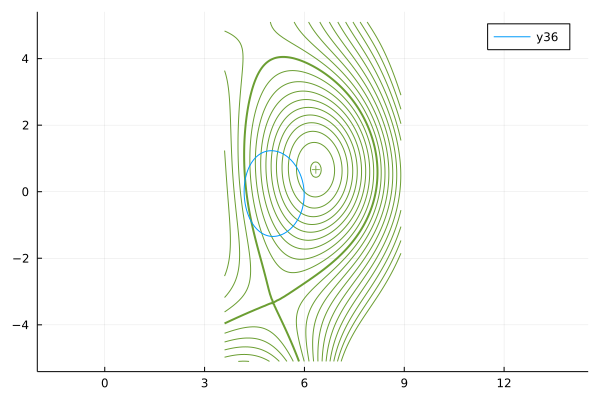

In [6]:
resize!(dd.equilibrium.time_slice,2);
eq=dd.equilibrium
eq.time_slice[2].global_quantities.psi_boundary=-0.12
α=0.25
eq.time_slice[2].boundary.outline.r,eq.time_slice[2].boundary.outline.z,_=IMAS.flux_surface(eq.time_slice[1],eq.time_slice[1].profiles_1d.psi[1]*(1-α)+eq.time_slice[1].profiles_1d.psi[end]*α)
eq.time_slice[2].boundary.outline.z.-=eq.time_slice[2].boundary.outline.z[argmin(eq.time_slice[2].boundary.outline.r)]
#eq.time_slice[2].boundary.outline.z.-=(maximum(eq.time_slice[2].boundary.outline.z)+minimum(eq.time_slice[2].boundary.outline.z))/2.0
eq.time_slice[2].boundary.outline.r.-=minimum(eq.time_slice[2].boundary.outline.r).-minimum(IMAS.flux_surface(eq.time_slice[1],eq.time_slice[1].profiles_1d.psi[end])[1])
eq.time_slice[2].time = -1.0
push!(eq.time,-1.0)

plot(dd.equilibrium.time_slice[1])
plot!(eq.time_slice[2].boundary.outline.r,eq.time_slice[2].boundary.outline.z)

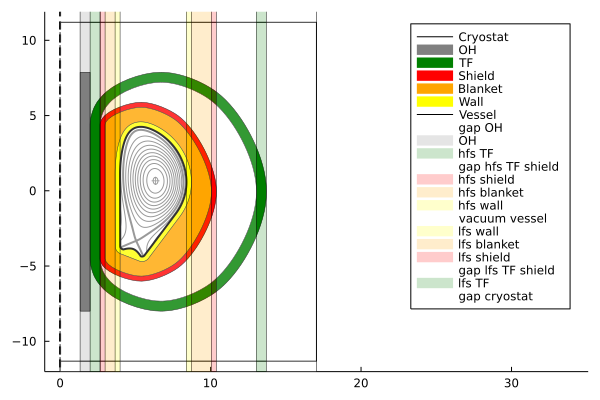

In [15]:
# initialize radial build IDS
eqt = dd.equilibrium.time_slice[1]

rb = dd.radial_build=IMAS.radial_build()
FUSE.init(rb, eqt, tf_shape_index=5, is_nuclear_facility=true, pf_inside_tf=true, pf_outside_tf=true);

cp = dd.core_profiles=IMAS.core_profiles()
FUSE.init(cp, ejima=0.4);

# run FluxSwingActor
ohactor = FUSE.FluxSwingActor(rb, eq, cp)
FUSE.step(ohactor)
FUSE.finalize(ohactor)

plot(eqt,color=:gray)
plot!(rb,outline=true)
display(plot!(rb,cx=false))

In [19]:
# initialize pf actor
pfoptactor = PFcoilsOptActor(dd.equilibrium, dd.radial_build, [6, 0, 6]; coil_model=:simple)
FUSE.step(pfoptactor, λ_ψ=1E-2, λ_null=1E+2, λ_currents=1E5, verbose=true, symmetric=true, maxiter=10000, optimization_scheme=:static);
FUSE.finalize(pfoptactor);

 * Status: success

 * Candidate solution
    Final objective value:     4.464902e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit 120)
    Iterations:    0
    f(x) calls:    9



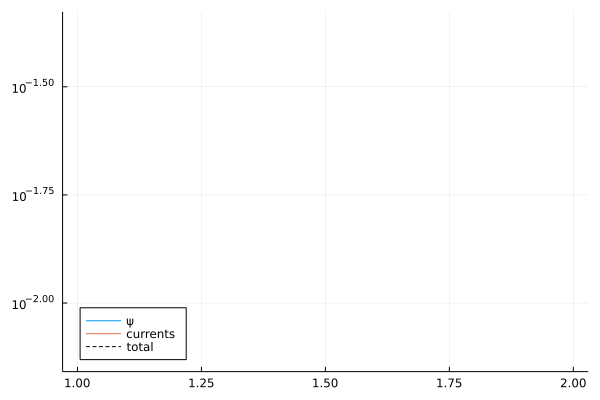

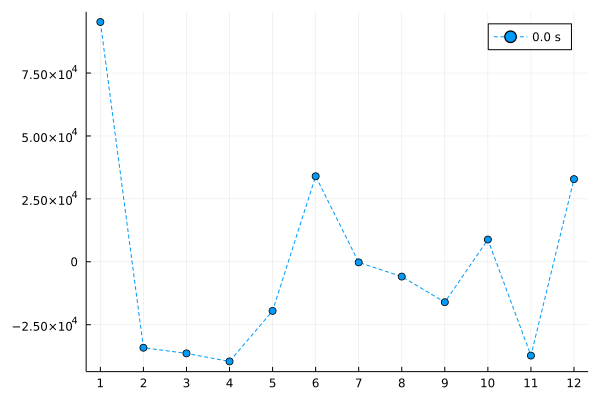

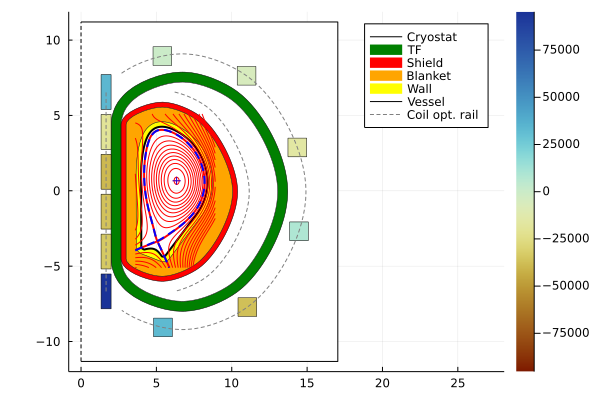

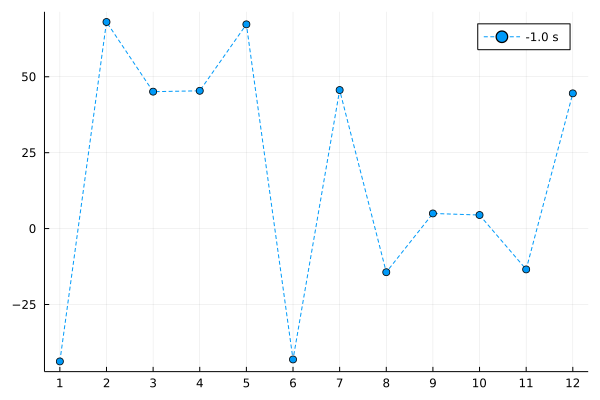

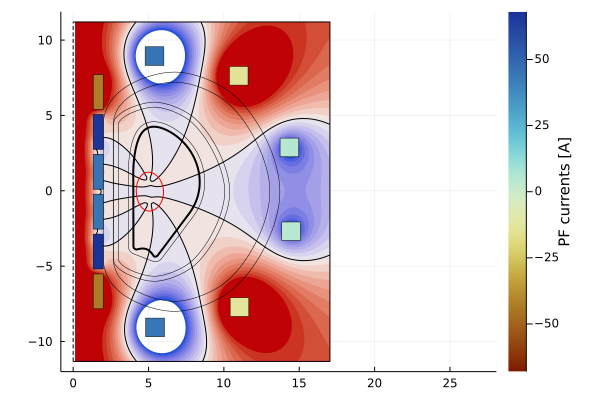

In [20]:
display(plot(pfoptactor.trace,:cost,start_at=1))

display(plot(pfoptactor.pf_active,:currents, time_index=1))
display(plot(pfoptactor,equilibrium=true,rail=true,time_index=1))

display(plot(pfoptactor.pf_active,:currents, time_index=2))
display(plot(pfoptactor,equilibrium=true,time_index=2))

In [21]:
# run pf actor
FUSE.step(pfoptactor, λ_ψ=1E-2, λ_null=1E+2, λ_currents=1E5, verbose=true, symmetric=true, maxiter=10000, optimization_scheme=:rail);
FUSE.finalize(pfoptactor);

 * Status: success

 * Candidate solution
    Final objective value:     2.682633e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   24  (vs limit 120)
    Iterations:    247
    f(x) calls:    614



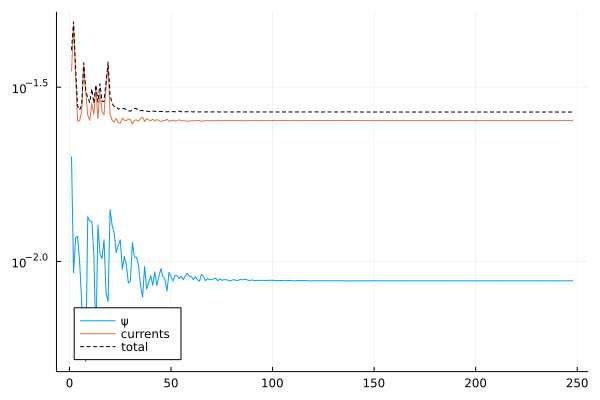

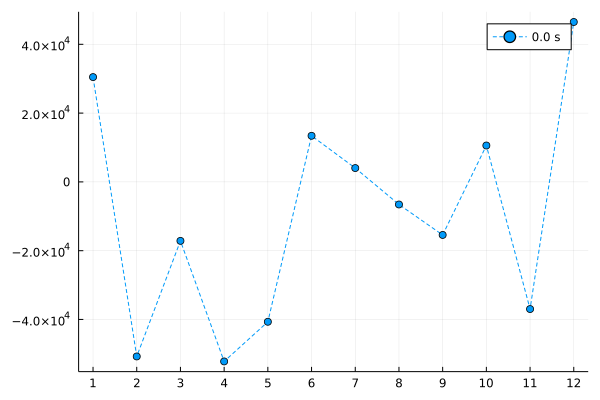

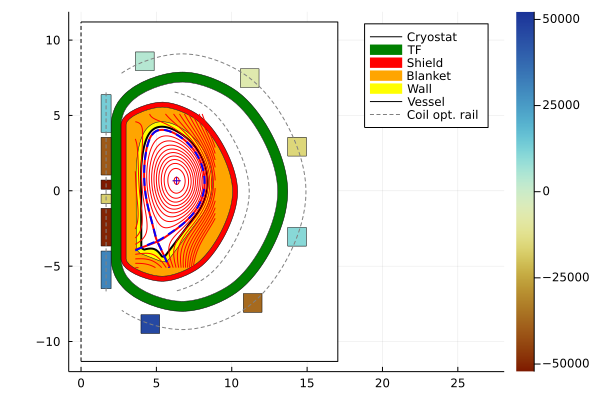

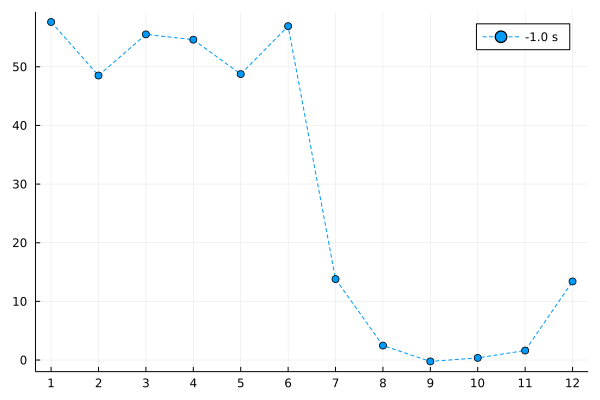

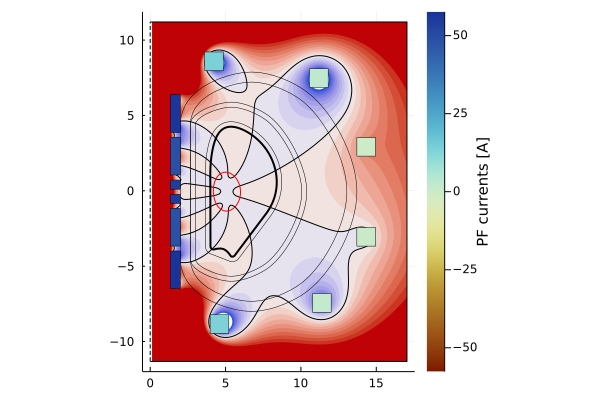

In [22]:
display(plot(pfoptactor.trace,:cost,start_at=1))

display(plot(pfoptactor.pf_active,:currents, time_index=1))
display(plot(pfoptactor,equilibrium=true,rail=true,time_index=1))

display(plot(pfoptactor.pf_active,:currents, time_index=2))
display(plot(pfoptactor,equilibrium=true,time_index=2,plot_r_buffer=1.0))

#IMAS.imas2json(rb,"radial_build_4.json")